# Dataset Preprocessing + Normalization + Tokenization for Native + Roman Script

In [ ]:
import os, zipfile, requests, json

# Download benchmark test set
url = "https://github.com/AI4Bharat/IndicLID/releases/download/v1.0/bhasha-abhijnaanam_test_set.zip"
os.makedirs("data", exist_ok=True)
zip_path = "data/bhasha_test.zip"

if not os.path.exists("data/bhasha_test"):
    print("Downloading benchmark test set...")
    r = requests.get(url)
    with open(zip_path, "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall("data/")
    os.remove(zip_path)
    print("Zip file removed.")

# Inspect files
os.listdir("data/")

Zip file removed.


['bhasha-abhijnaanam.json']

In [ ]:
import json
import pandas as pd

def load_json(path):
    with open(path, "r", encoding="utf-8") as f:
        obj = json.load(f)   # one JSON object
    data = obj["data"]

    # build DataFrame
    df = pd.DataFrame([{
        "id": d["unique_identifier"],
        "native": d["native sentence"],
        "roman": d["romanized sentence"],
        "label": d["language"],
        "script": d["script"],
        "source": d["source"]
    } for d in data])

    return df

# usage
df = load_json("data/bhasha-abhijnaanam.json")

In [ ]:
print(df.shape)
df.sample(2)

(88014, 6)


,id,native,roman,label,script,source
27056,kn_642,ಇಂಗಾಲದಂತಹ ಅಲೋಹಗಳನ್ನು ಸಣ್ಣ ಪ್ರಮಾಣದಲ್ಲಿ ಬೆರೆಸಿದ ...,,Kannada,Kannada,Flores-200
55829,sd_2261,(فارسي متن جي سامهون واري صفحي تي سنڌي نثر ۾ ت...,(faarsi mtin je samhun ware sfhe te sindhi nsr...,Sindhi,Perso-Arabic,Dakshina


In [ ]:
native_test = df[['native', 'label']]
roman_test = df[['roman', 'label']]

In [ ]:
roman_test = roman_test[roman_test['roman'] != '']
native_test = native_test[native_test['native'] != '']

In [ ]:
native_test['label'].unique()

array(['Assamese', 'Bodo', 'Bangla', 'Konkani', 'Gujarati', 'Hindi',
       'Kannada', 'Maithili', 'Malayalam', 'Marathi', 'Nepali', 'Oriya',
       'Punjabi', 'Sanskrit', 'Sindhi', 'Tamil', 'Telugu', 'Urdu',
       'Kashmiri', 'Manipuri', 'Dogri', 'Santali'], dtype=object)

In [ ]:
native_test[native_test['label'] == 'Hindi'].sample(1).iloc[0].native

'पुनर्नवीनीकरण के नए तरीके रोज़ इजाद हो रहे हैं और नीचे संक्षिप्त मीन लिखे हैं'

In [ ]:
native_test.sample()

,native,label
83877,ওপরেসন তৌদ্রিবা ত্রান্সজেন্দর ওইবা মীশিংনা মখো...,Manipuri


In [ ]:
!pip install indic-nlp-library --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 6.2 MB/s eta 0:00:00


In [ ]:
from indicnlp.normalize.indic_normalize import IndicNormalizerFactory
from indicnlp.tokenize import indic_tokenize

In [ ]:
# Map dataset labels to ISO codes IndicNLP understands
lang_code_map = {
    'Assamese': 'as',
    'Bodo': 'brx',
    'Bangla': 'bn',
    'Konkani': 'gom',
    'Gujarati': 'gu',
    'Hindi': 'hi',
    'Kannada': 'kn',
    'Maithili': 'mai',
    'Malayalam': 'ml',
    'Marathi': 'mr',
    'Nepali': 'ne',
    'Oriya': 'or',
    'Punjabi': 'pa',
    'Sanskrit': 'sa',
    'Sindhi': 'sd',
    'Tamil': 'ta',
    'Telugu': 'te',
    'Urdu': 'ur',
    'Kashmiri': 'ks',
    'Manipuri': 'mni',
    'Dogri': 'doi',
    'Santali': 'sat'  # ⚠️ Santali is Ol Chiki script, may not be fully supported in IndicNLP
}

In [ ]:
import unicodedata

def fallback_normalize(text):
    return " ".join(unicodedata.normalize("NFKC", text).split())

In [ ]:
def preprocess_text(df):
    processed_texts = []
    factory = IndicNormalizerFactory()

    for idx, row in df.iterrows():
        text , label = row.iloc[0], row.iloc[1]
        lang = lang_code_map.get(label)  # fallback Hindi if unknown

        try:
            # Create normalizer for the specific language
            normalizer = factory.get_normalizer(lang)
            norm_text = normalizer.normalize(text)

            # Tokenize
            tokens = indic_tokenize.trivial_tokenize(norm_text, lang)
            processed_texts.append(" ".join(tokens))

        except Exception as e:
            # If not supported in IndicNLP, just keep raw text
            print(f"⚠️ Skipping normalization for {label} (lang={lang}): {e}")
            norm_text = fallback_normalize(text)
            processed_texts.append(text)

    return processed_texts

In [ ]:
native_test['processed'] = preprocess_text(native_test)
roman_test['processed'] = preprocess_text(roman_test)

Streaming output truncated to the last 5000 lines.
⚠️ Skipping normalization for Urdu (lang=ur): No module named 'urduhack'
⚠️ Skipping normalization for Urdu (lang=ur): No module named 'urduhack'
⚠️ Skipping normalization for Urdu (lang=ur): No module named 'urduhack'
⚠️ Skipping normalization for Urdu (lang=ur): No module named 'urduhack'
⚠️ Skipping normalization for Urdu (lang=ur): No module named 'urduhack'
⚠️ Skipping normalization for Urdu (lang=ur): No module named 'urduhack'
⚠️ Skipping normalization for Urdu (lang=ur): No module named 'urduhack'
⚠️ Skipping normalization for Urdu (lang=ur): No module named 'urduhack'
⚠️ Skipping normalization for Urdu (lang=ur): No module named 'urduhack'
⚠️ Skipping normalization for Urdu (lang=ur): No module named 'urduhack'
⚠️ Skipping normalization for Urdu (lang=ur): No module named 'urduhack'
⚠️ Skipping normalization for Urdu (lang=ur): No module named 'urduhack'
⚠️ Skipping normalization for Urdu (lang=ur): No module named 'urduhack'


In [ ]:
native_test.to_csv('native_test.csv', index=False)
roman_test.to_csv('roman_test.csv', index=False)

In [ ]:
# Sample one row where label is 'Hindi'
sample_row = native_test[native_test['label'] == 'Hindi'].sample(1).iloc[0]
native_text, processed_text = sample_row.iloc[0], sample_row.iloc[2]
native_text, processed_text

('उनके उत्तराधिकारी, जुनेद इब्न अब्द अल-रहमान अल-मुरी, ने 730 सी.',
 'उनके उत्तराधिकारी , जुनेद इब्न अब्द अल - रहमान अल - मुरी , ने 730 सी .')

In [ ]:
# Sample one row where label is 'Hindi'
sample_row = roman_test[roman_test['label'] == 'Hindi'].sample(1).iloc[0]
roman_text, processed_text = sample_row.iloc[0], sample_row.iloc[2]
roman_text, processed_text

('Khilji vansh ka shasan savant 1377 tak mana gaya hai.',
 'Khilji vansh ka shasan savant 1377 tak mana gaya hai .')

# Model loading

In [ ]:
# model zips
model_urls = {
    "IndicLID-FTN": "https://github.com/AI4Bharat/IndicLID/releases/download/v1.0/indiclid-ftn.zip",
    "IndicLID-FTR": "https://github.com/AI4Bharat/IndicLID/releases/download/v1.0/indiclid-ftr.zip",
    "IndicBERT": "https://github.com/AI4Bharat/IndicLID/releases/download/v1.0/indiclid-bert.zip"
}

os.makedirs("models", exist_ok=True)

for name, url in model_urls.items():
    zip_path = f"models/{name}.zip"
    if not os.path.exists(f"models/{name}"):
        print(f"Downloading {name}...")
        r = requests.get(url)
        with open(zip_path, "wb") as f:
            f.write(r.content)
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(f"models/")
        os.remove(zip_path)
        print("Zip file removed.")

Zip file removed.
Zip file removed.
Zip file removed.


In [ ]:
!pip3 install fasttext transformers --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import fasttext
fasttext_native_model = fasttext.load_model('models/indiclid-ftn/model_baseline_roman.bin')

In [ ]:
fasttext_roman_model = fasttext.load_model('models/indiclid-ftr/model_baseline_roman.bin')

# Fasttext on Native Dataset

In [ ]:
!pip install numpy==1.26.4 --quiet

In [ ]:
label_map = {
    'asm_Beng': 'Assamese',
    'ben_Beng': 'Bangla',
    'brx_Deva': 'Bodo',
    'doi_Deva': 'Dogri',
    'guj_Gujr': 'Gujarati',
    'hin_Deva': 'Hindi',
    'kan_Knda': 'Kannada',
    'kok_Deva': 'Konkani',
    'mai_Deva': 'Maithili',
    'mal_Mlym': 'Malayalam',
    'mar_Deva': 'Marathi',
    'mni_Beng': 'Manipuri',
    'mni_Meti': 'Manipuri',  # if both used
    'nep_Deva': 'Nepali',
    'ori_Orya': 'Oriya',
    'pan_Guru': 'Punjabi',
    'san_Deva': 'Sanskrit',
    'sat_Olch': 'Santali',
    'snd_Arab': 'Sindhi',
    'tam_Tamil': 'Tamil',
    'tel_Telu': 'Telugu',
    'urd_Arab': 'Urdu',
    'kas_Deva': 'Kashmiri',
    'kas_Arab': 'Kashmiri',
    'other': 'other',
    'eng_Latn': 'English',  # if applicable
}

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_fasttext(model, df, text_col, label_col):
    texts = df[text_col].tolist()
    labels = df[label_col].tolist()

    preds = []
    for text in texts:
        label_pred, _ = model.predict(text)
        # remove __label__ prefix
        pred_key = label_pred[0].replace("__label__", "")
        # map to English label if exists, else keep original
        pred_label = label_map.get(pred_key)
        preds.append(pred_label)

    acc = accuracy_score(labels, preds)
    print(f"\nFastText Accuracy on {text_col}: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(labels, preds))

    return pd.DataFrame({
        "text": texts,
        "true": labels,
        "pred": preds
    })

In [ ]:
import pandas as pd
native_test = pd.read_csv('native_test.csv')

In [ ]:
import time
before = time.time()
native_ft_results = evaluate_fasttext(fasttext_native_model, native_test, "processed", "label")
after = time.time()


FastText Accuracy on processed: 0.9864


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Classification Report:
               precision    recall  f1-score   support

    Assamese       0.99      1.00      0.99      1524
      Bangla       1.00      1.00      1.00      5612
        Bodo       0.98      0.99      0.99      1502
       Dogri       0.99      0.94      0.96      1500
     English       0.00      0.00      0.00         0
    Gujarati       1.00      1.00      1.00      5801
       Hindi       0.95      0.94      0.95      5628
     Kannada       1.00      1.00      1.00      5861
    Kashmiri       0.96      0.98      0.97      3530
     Konkani       0.97      0.98      0.98      1500
    Maithili       0.85      0.92      0.89      2515
   Malayalam       1.00      1.00      1.00      5639
    Manipuri       1.00      1.00      1.00      2514
     Marathi       0.99      0.95      0.97      5629
      Nepali       0.98      1.00      0.99      2514
       Oriya       1.00      1.00      1.00      1524
     Punjabi       1.00      1.00      1.00      5794
  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = native_ft_results['true'].tolist()
preds_final = native_ft_results['pred'].tolist()

Fastext_accuracy = accuracy_score(y_true, preds_final)
Fastext_precision = precision_score(y_true, preds_final, average='macro', zero_division=0)
Fastext_recall = recall_score(y_true, preds_final, average='macro', zero_division=0)
Fastext_f1 = f1_score(y_true, preds_final, average='macro', zero_division=0)

print("Fastext_Native Accuracy:", Fastext_accuracy*100)
print("Fastext_Native Precision (macro):", Fastext_precision*100)
print("Fastext_Native Recall (macro):", Fastext_recall*100)
print("Fastext_Native F1-score (macro):", Fastext_f1*100)
print(f"Throughput: {len(native_test)/(after-before)} sentence/seconds")

Fastext_Native Accuracy: 98.64453382416434
Fastext_Native Precision (macro): 90.09182410636703
Fastext_Native Recall (macro): 90.33290945599157
Fastext_Native F1-score (macro): 90.20010073938045
Throughput: 22431.458425198267 sentence/seconds


In [ ]:
set(native_ft_results['pred'].unique()) - set(native_ft_results['true'].unique())

{'English', 'other'}

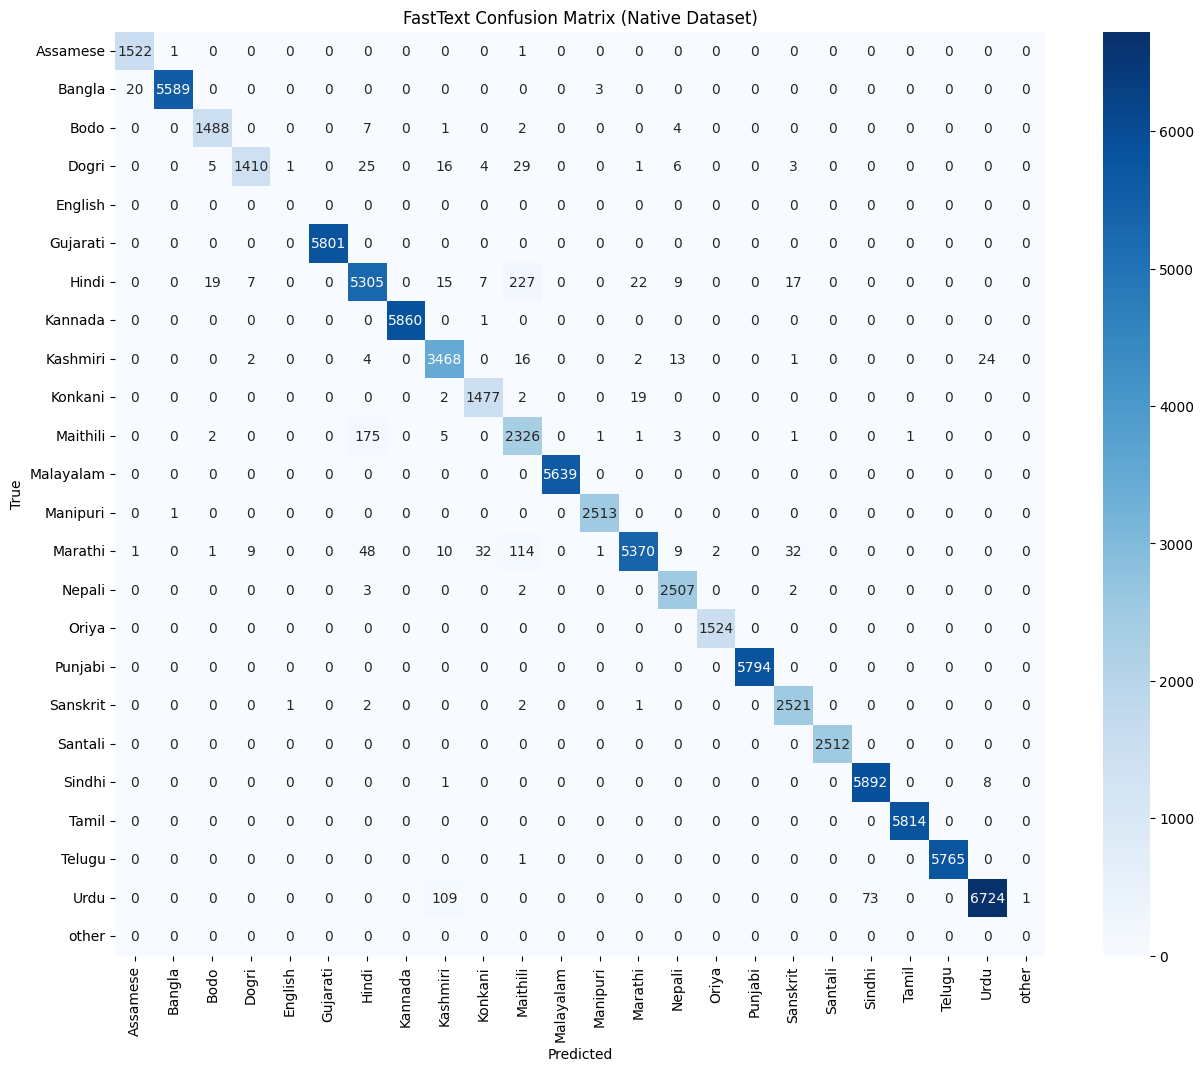

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(df_results, title):
    # Get unique labels from both true and pred columns
    labels = sorted(set(df_results['true'].unique()) | set(df_results['pred'].unique()))

    cm = confusion_matrix(df_results['true'], df_results['pred'], labels=labels)

    plt.figure(figsize=(15, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# Optional: FastText confusion matrix
plot_confusion_matrix(native_ft_results, "FastText Confusion Matrix (Native Dataset)")

# NLLB on native

In [ ]:
!pip install transformers sentencepiece --quiet

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load tokenizer and model
model_name = "facebook/nllb-200-distilled-600M"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

In [ ]:
indian_langs = [
    "asm_Beng", "ben_Beng", "brx_Deva", "doi_Deva", "guj_Gujr",
    "hin_Deva", "kan_Knda", "kas_Arab", "kok_Deva", "mai_Deva",
    "mal_Mlym", "mni_Beng", "mar_Deva", "nep_Deva", "ori_Orya",
    "pan_Guru", "san_Deva", "sat_Olck", "snd_Arab", "tam_Taml",
    "tel_Telu", "urd_Arab"
]

nllb_ft_to_true_label = {
    'asm_Beng': 'as',
    'ben_Beng': 'bn',
    'brx_Deva': 'brx',
    'doi_Deva': 'doi',
    'guj_Gujr': 'gu',
    'hin_Deva': 'hi',
    'kan_Knda': 'kn',
    'kas_Arab': 'ks',
    'kok_Deva': 'gom',
    'mai_Deva': 'mai',
    'mal_Mlym': 'ml',
    'mni_Beng': 'mni',
    'mar_Deva': 'mr',
    'nep_Deva': 'ne',
    'ori_Orya': 'or',
    'pan_Guru': 'pa',
    'san_Deva': 'sa',
    'sat_Olck': 'sat',
    'snd_Arab': 'sd',
    'tam_Taml': 'ta',
    'tel_Telu': 'te',
    'urd_Arab': 'ur'
}

def predict_language(text):
    scores = {}
    for lang in indian_langs:
        try:
            tokens = tokenizer(text, return_tensors="pt", src_lang=lang)
            # Number of tokens as proxy score
            scores[lang] = tokens.input_ids.size(1)
        except:
            scores[lang] = 0
    predicted_lang = max(scores, key=scores.get)
    return predicted_lang

# Predict languages for all samples
start_time_nllb = time.time()
preds_nllb = [predict_language(text) for text in native_test['processed']]
end_time_nllb = time.time()

# Map to short ISO codes
preds_final_nllb = [label_map.get(p, p) for p in preds_nllb]

print(len(preds_final_nllb))

88014


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_true = native_test['label'].tolist()

NLLB_accuracy = accuracy_score(y_true, preds_final_nllb)
NLLB_precision = precision_score(y_true, preds_final_nllb, average='macro', zero_division=0)
NLLB_recall = recall_score(y_true, preds_final_nllb, average='macro', zero_division=0)
NLLB_f1 = f1_score(y_true, preds_final_nllb, average='macro', zero_division=0)

print("NLLB_Overall Accuracy:", NLLB_accuracy*100)
print("NLLB_Overall Precision (macro):", NLLB_precision*100)
print("NLLB_Overall Recall (macro):", NLLB_recall*100)
print("NLLB_Overall F1-score (macro):", NLLB_f1*100)

NLLB_throughput = len(preds_final_nllb) / (end_time_nllb - start_time_nllb)  # samples/sec
print("NLLB_Throughput (samples/sec):", NLLB_throughput)

NLLB_Overall Accuracy: 1.731542709114459
NLLB_Overall Precision (macro): 0.07870648677792996
NLLB_Overall Recall (macro): 4.545454545454546
NLLB_Overall F1-score (macro): 0.15473369356636796
NLLB_Throughput (samples/sec): 1504.879216823468


In [ ]:
set(preds_final_nllb)

{'as'}

# Fasttext on roman dataset

In [ ]:
roman_test = pd.read_csv('roman_test.csv')

In [ ]:
roman_samples = roman_test["processed"].tolist()
batch_size = 16
start = time.time()

r_predictions = fasttext_roman_model.predict(roman_samples,k=1)
# k=1 means return only the top prediction

end = time.time()
r_predicted_labels = r_predictions[0]

In [ ]:
code_to_lang = {
    'asm': 'Assamese',
    'ben': 'Bangla',
    'brx': 'Bodo',
    'guj': 'Gujarati',
    'hin': 'Hindi',
    'kan': 'Kannada',
    'kas': 'Kashmiri',
    'kok': 'Konkani',
    'mai': 'Maithili',
    'mal': 'Malayalam',
    'mni': 'Manipuri',
    'mar': 'Marathi',
    'nep': 'Nepali',
    'ori': 'Oriya',
    'pan': 'Punjabi',
    'san': 'Sanskrit',
    'snd': 'Sindhi',
    'tam': 'Tamil',
    'tel': 'Telugu',
    'urd': 'Urdu',
}

In [ ]:
r_cleaned_predictions = [
    label[0].replace('__label__', '')
    for label in r_predicted_labels
]

r_preds_mapped = [p_r.split('_')[0] for p_r in r_cleaned_predictions]
r_preds_final = [code_to_lang.get(p_r, p_r) for p_r in r_preds_mapped]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

r_y_true = roman_test['label'].tolist()

Fastext_roman_accuracy = accuracy_score(r_y_true, r_preds_final)
Fastext_roman_precision = precision_score(r_y_true, r_preds_final, average='macro', zero_division=0)
Fastext_roman_recall = recall_score(r_y_true, r_preds_final, average='macro', zero_division=0)
Fastext_roman_f1 = f1_score(r_y_true, r_preds_final, average='macro', zero_division=0)

print("Fastext_roman Accuracy:", Fastext_roman_accuracy*100)
print("Fastext_roman Precision (macro):", Fastext_roman_precision*100)
print("Fastext_roman Recall (macro):", Fastext_roman_recall*100)
print("Fastext_roman F1-score (macro):", Fastext_roman_f1*100)

Fastext_roman_throughput = len(r_predicted_labels) / (end - start)  # samples/sec
print("Fastext_roman_Throughput (samples/sec):", Fastext_roman_throughput)

Fastext_roman Accuracy: 70.35882553160997
Fastext_roman Precision (macro): 56.63434447353731
Fastext_roman Recall (macro): 70.74914718907024
Fastext_roman F1-score (macro): 56.59836958819638
Fastext_roman_Throughput (samples/sec): 28292.180667614048


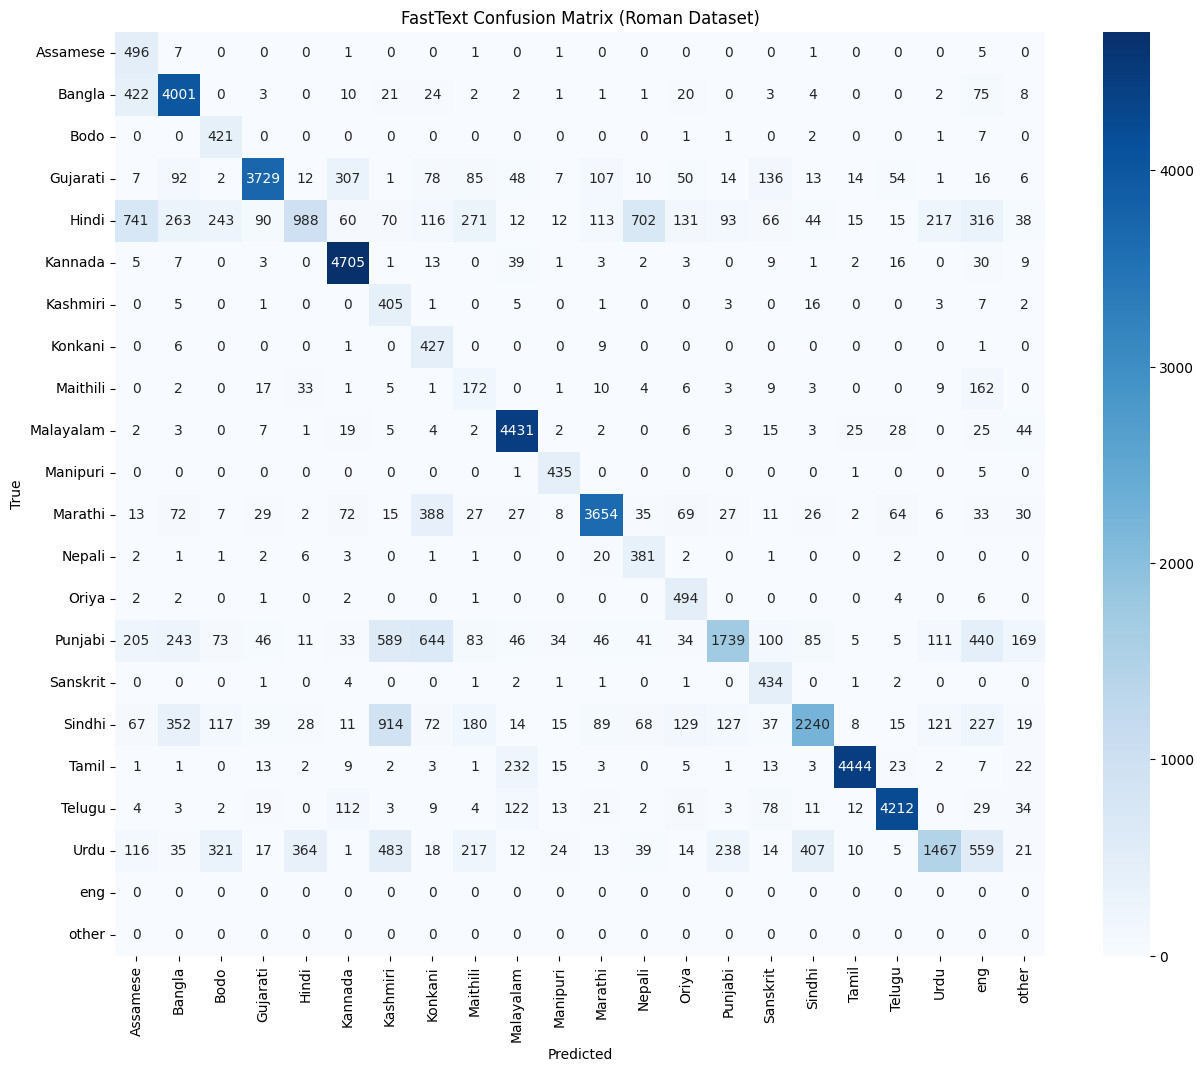

In [ ]:
roman_ft_results = pd.DataFrame({
    'true': r_y_true,
    'pred': r_preds_final
})

plot_confusion_matrix(roman_ft_results, "FastText Confusion Matrix (Roman Dataset)")

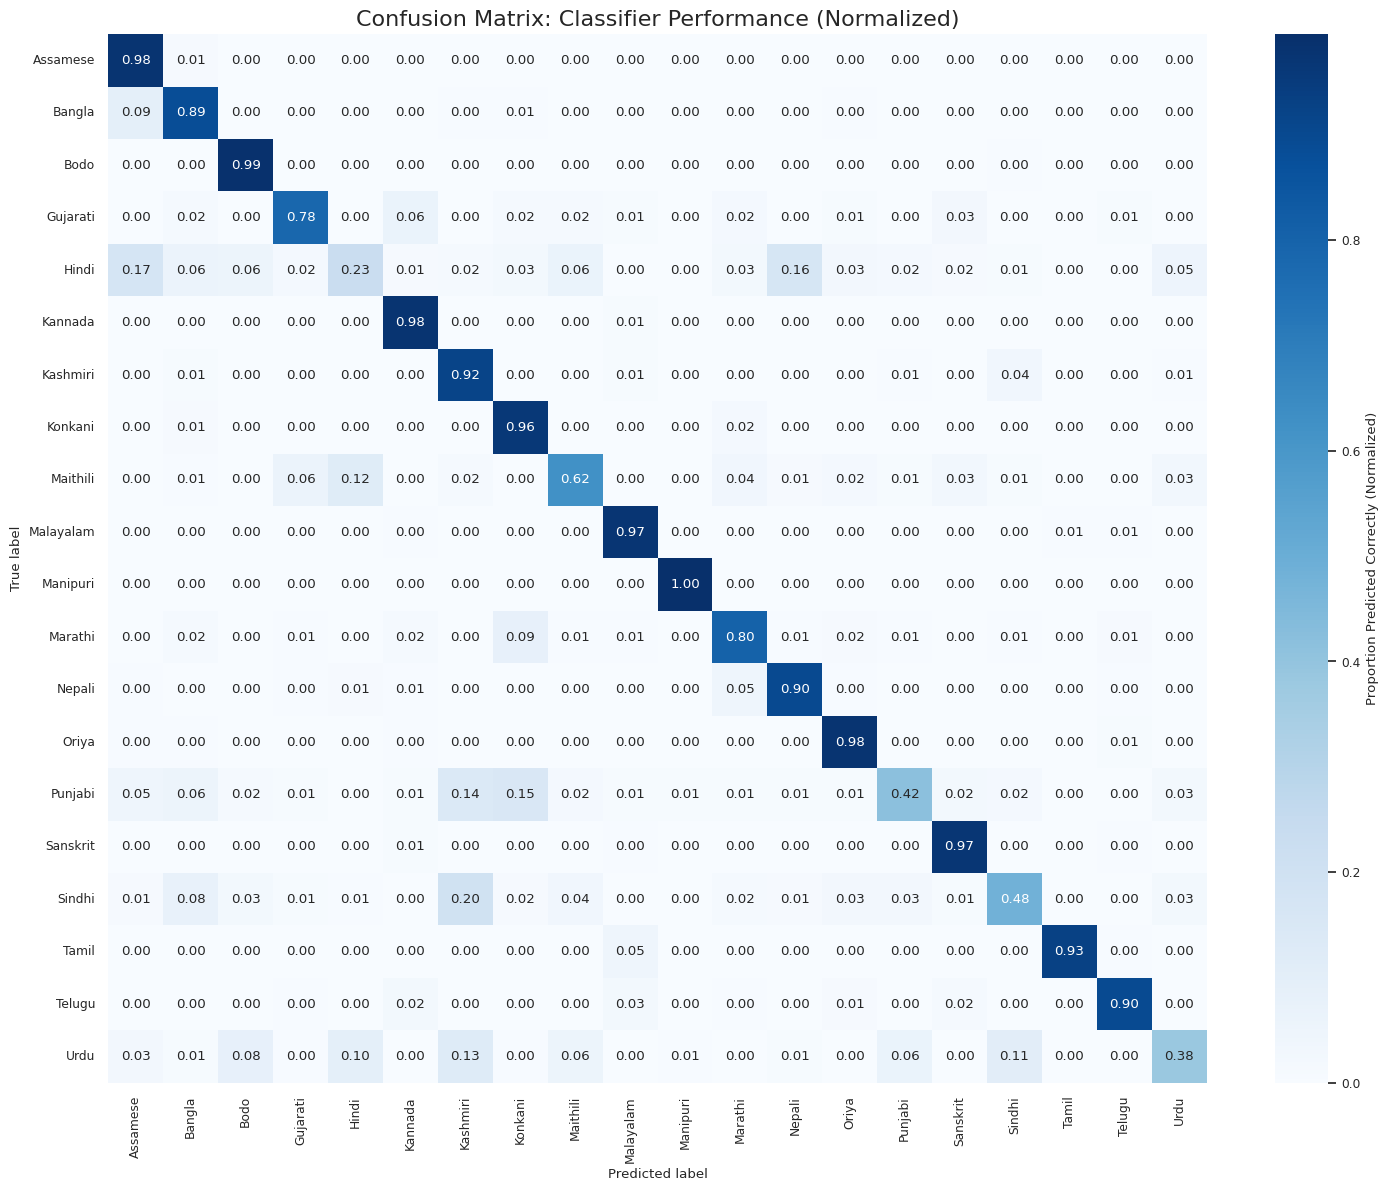

In [79]:
cm_raw = confusion_matrix(r_y_true, r_preds_final, labels=np.unique(r_y_true))

cm_normalized = cm_raw.astype('float') / cm_raw.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cm_normalized, index=np.unique(r_y_true), columns=np.unique(r_y_true))

plt.figure(figsize=(15, 12))
sns.set(font_scale=0.8)

# Create the heatmap
sns.heatmap(
    cm_df,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar_kws={'label': 'Proportion Predicted Correctly (Normalized)'}
)

# Customization
plt.title('Confusion Matrix: Classifier Performance (Normalized)', fontsize=16)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()